In [11]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout 
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from termcolor import colored

from glob import glob
from scipy.io import loadmat
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, roc_curve
from keras.metrics import MeanIoU
from keras.utils import to_categorical
from keras import backend as K
import statistics
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate

In [12]:
image_path = 'C:/Users/leekh/Desktop/drone/dataset/semantic_drone_dataset/original_images/'
mask_path = 'C:/Users/leekh/Desktop/drone/dataset/semantic_drone_dataset/label_images_semantic/'

IMAGE_SIZE = 256 
NUM_CLASSES = 23

In [13]:
image_list = os.listdir(image_path)
im_list = image_list
mask_list = os.listdir(mask_path)

In [14]:
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in im_list]

for x in range(0,400):
    mask_list[x] = mask_list[x][:-4] + '.png'

In [15]:
import tensorflow as tf
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\original_images\\000.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\original_images\\001.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\original_images\\002.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\leekh\\Desktop\\drone\\dataset\\semantic_drone_dataset\\label_images_semantic\\002.png'>)


In [16]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'C:/Users/leekh/Desktop/drone/dataset/semantic_drone_dataset/original_images/000.jpg', shape=(), dtype=string)
tf.Tensor(b'C:/Users/leekh/Desktop/drone/dataset/semantic_drone_dataset/label_images_semantic/000.png', shape=(), dtype=string)


In [17]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 256), method='nearest')
    input_mask = tf.image.resize(mask, (256, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [18]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [19]:
EPOCHS = 350
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 8

processed_image_ds=processed_image_ds.shuffle(BUFFER_SIZE)

ts=len(processed_image_ds)
val_dataset=processed_image_ds.skip(int(ts*0.8))
train_dataset=processed_image_ds.take(int(ts*0.8))

print(len(val_dataset))
print(len(train_dataset))

val_dataset.batch(BATCH_SIZE)
train_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(len(val_dataset))
print(len(train_dataset))
print(processed_image_ds.element_spec)

80
320
10
40
(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))


In [20]:
def evaluateMask(true_mask, predicted_mask): 
    # Flatten the masks to 1D arrays
    true_mask = to_categorical(true_mask.numpy().flatten(), num_classes=23)
    predicted_mask = to_categorical(predicted_mask.numpy().flatten(), num_classes=23)
    
    # Mean Iou Score
    mean_iou = MeanIoU(num_classes=23)
    mean_iou.update_state(true_mask, predicted_mask)
    iou_score = mean_iou.result().numpy()
    
    # Confusion matrix
    cm = confusion_matrix(np.argmax(true_mask, axis=1), np.argmax(predicted_mask, axis=1), labels=range(23))
    
    # Calculate the metrics
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    tn = np.sum(cm) - (tp + fp + fn)

    precision = tp / (tp + fp)
    precision_mean = np.mean(np.nan_to_num(precision))
    recall = tp / (tp + fn)
    recall_mean = np.mean(np.nan_to_num(recall))
    accuracy = np.sum(tp) / np.sum(cm)
    f1_score = 2 * precision * recall / (precision + recall)
    f1_score_mean = np.mean(np.nan_to_num(f1_score))
    dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
    dice_coefficient_mean = np.mean(np.nan_to_num(dice_coefficient))
    
    # Print the results
    print("Classification Report:\n", classification_report(np.argmax(true_mask, axis=1), np.argmax(predicted_mask, axis=1)))
    print("Mean IoU score:", iou_score)
    print("Recall:", recall_mean)
    print("Precision:", precision_mean)
    print("Accuracy:", accuracy)
    print("F1 score:", f1_score_mean)
    print("Dice coefficient:", dice_coefficient_mean)

    # Plot the confusion matrix
    sns.heatmap(cm, xticklabels=['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7'
                                 , 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14'
                                 , 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 
                                 'P21', 'P22'], 
                yticklabels=['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'
                            , 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'
                            , 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22'],
    annot=True, fmt='d', annot_kws={'fontsize':6}, cmap="YlGnBu")

In [21]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

In [22]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask 1', 'Predicted Mask 2', 'Ensemble Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [23]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [24]:
# Load pretrained models
deeplabv3plus = load_model('deeplabv3plus.h5')

In [25]:
unet = load_model('unet.h5')

In [26]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

# Ensemble 1 - Model averaging

1/1 [==============================] - 6s 6s/step
Deeplabv3plus:

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.99      0.99     57315
           8       0.91      0.26      0.41        38
          10       0.95      1.00      0.98      1685
          15       0.92      0.99      0.95      2678
          18       0.86      0.91      0.89       411
          22       0.98      0.94      0.96      3409

    accuracy                           0.99     65536
   macro avg       0.94      0.85      0.86     65536
weighted avg       0.99      0.99      0.99     65536

Mean IoU score: 0.9895408
Recall: 0.22160276362392178
Precision: 0.2442243529895032
Accuracy: 0.989898681640625
F1 score: 0.22505512287924312
Dice coefficient: 0.22505512287924312
Unet:



c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           1       0.95      0.99      0.97     57315
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           8       1.00      0.05      0.10        38
           9       0.00      0.00      0.00         0
          10       0.40      0.21      0.28      1685
          11       0.00      0.00      0.00         0
          15       0.87      0.70      0.78      2678
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00       411
          21       0.00      0.00      0.00         0
          22       0.66      0.24      0.35      3409

    accuracy                           0.91     65536
   macro avg       0.32      0.18      0.21     65536
weighted avg       0.92      0.91      0.91     65536

Mean IoU score: 0.9168224
Recall: 0.09573011621737697
Precision: 0.16866876950636953
Accuracy: 0.913894653320

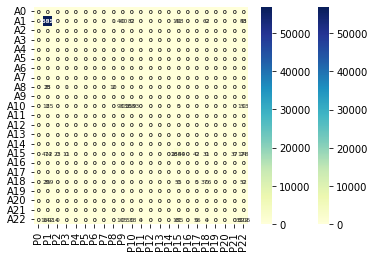

In [27]:
for image, mask in val_dataset.take(1):
    outputs1 = deeplabv3plus.predict(image)
    outputs2 = unet.predict(image)
    
    # Deeplabv3plus performance
    print("Deeplabv3plus:\n")
    evaluateMask(mask[0], create_mask(outputs1))
    
    # Unet performance
    print("Unet:\n")
    evaluateMask(mask[0], create_mask(outputs2))

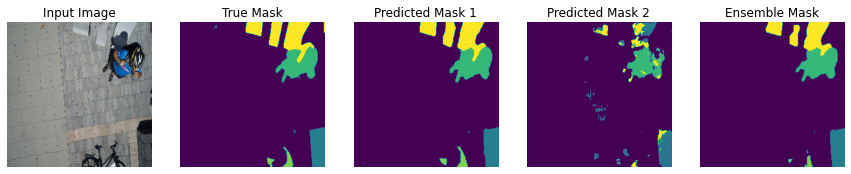

Model Averaging:



c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           1       0.99      1.00      0.99     57315
           8       0.83      0.13      0.23        38
          10       0.99      0.97      0.98      1685
          15       0.93      0.97      0.95      2678
          17       0.00      0.00      0.00         0
          18       1.00      0.45      0.62       411
          22       0.99      0.82      0.90      3409

    accuracy                           0.98     65536
   macro avg       0.82      0.62      0.67     65536
weighted avg       0.98      0.98      0.98     65536

Mean IoU score: 0.9829619
Recall: 0.18847460057237717
Precision: 0.2488617673406772
Accuracy: 0.9834442138671875
F1 score: 0.20259088662815206
Dice coefficient: 0.20259088662815206


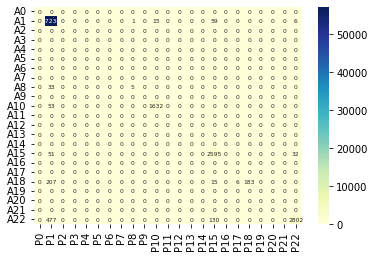

In [28]:
outputs = (outputs1 + outputs2) / 2  

display([image[0], mask[0], create_mask(outputs1), create_mask(outputs2), create_mask(outputs)])
    
# After model averaging
print("Model Averaging:\n")
evaluateMask(mask[0], create_mask(outputs))

# Ensemble 2 - Model Averaging (Weighted)

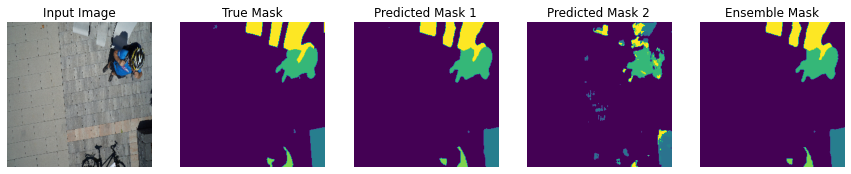

Model Averaging (Weighted):

Classification Report:
               precision    recall  f1-score   support

           1       0.99      1.00      0.99     57315
           8       0.86      0.16      0.27        38
          10       0.97      0.99      0.98      1685
          15       0.93      0.98      0.95      2678
          18       0.93      0.83      0.88       411
          22       0.98      0.91      0.95      3409

    accuracy                           0.99     65536
   macro avg       0.94      0.81      0.84     65536
weighted avg       0.99      0.99      0.99     65536

Mean IoU score: 0.9892123
Recall: 0.2117983603592957
Precision: 0.2464839653829284
Accuracy: 0.9895782470703125
F1 score: 0.2184428712303119
Dice coefficient: 0.21844287123031186


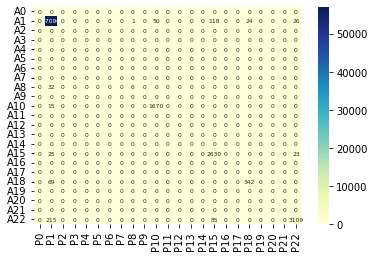

In [29]:
# Define the weights for each model's prediction
weights = [0.8, 0.2]
    
weightedOutput = np.average([outputs1, outputs2], axis=0, weights=weights)
    
display([image[0], mask[0], create_mask(outputs1), create_mask(outputs2), create_mask(weightedOutput)])
    
# After model averaging (Weighted)
print("Model Averaging (Weighted):\n")
evaluateMask(mask[0], create_mask(weightedOutput))

# Ensemble 3 - Max Ensemble

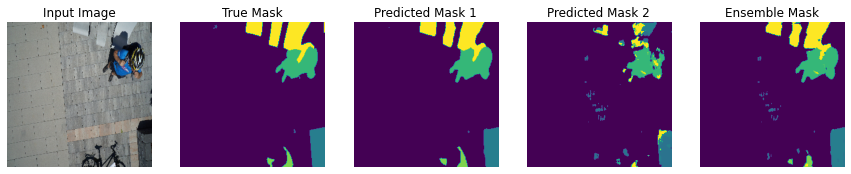

Max Ensemble:



c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           1       0.99      0.99      0.99     57315
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           8       0.83      0.13      0.23        38
           9       0.00      0.00      0.00         0
          10       0.98      0.94      0.96      1685
          15       0.92      0.96      0.94      2678
          17       0.00      0.00      0.00         0
          18       0.92      0.59      0.72       411
          21       0.00      0.00      0.00         0
          22       0.98      0.87      0.92      3409

    accuracy                           0.98     65536
   macro avg       0.51      0.41      0.43     65536
weighted avg       0.99      0.98      0.98     65536

Mean IoU score: 0.9796332
Recall: 0.19511405393417877
Precision: 0.24429057251506905
Accuracy: 0.9801483154296875
F1 score: 0.20683955366992832
Dice coefficient: 0

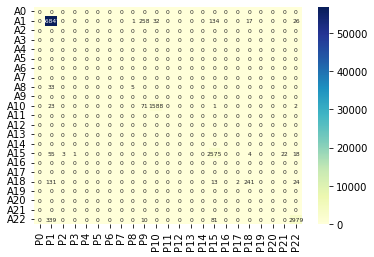

In [30]:
# Get the maximum probability for each class across the two models
maxOutput = np.maximum(outputs1, outputs2)

# Display the images and masks
display([image[0], mask[0], create_mask(outputs1), create_mask(outputs2), create_mask(maxOutput)])

# After max ensemble
print("Max Ensemble:\n")
evaluateMask(mask[0], create_mask(maxOutput))

# Ensemble 4 - Min Ensemble

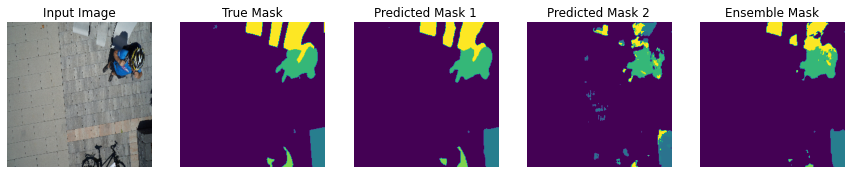

Max Ensemble:



c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           1       0.97      1.00      0.99     57315
           3       0.00      0.00      0.00         0
           8       0.83      0.13      0.23        38
          10       0.99      0.92      0.96      1685
          15       0.91      0.85      0.88      2678
          17       0.00      0.00      0.00         0
          18       0.97      0.21      0.35       411
          21       0.00      0.00      0.00         0
          22       0.90      0.66      0.76      3409

    accuracy                           0.97     65536
   macro avg       0.62      0.42      0.46     65536
weighted avg       0.97      0.97      0.96     65536

Mean IoU score: 0.9669267
Recall: 0.16412599762076124
Precision: 0.24241153339518343
Accuracy: 0.967376708984375
F1 score: 0.18073959357295866
Dice coefficient: 0.18073959357295866


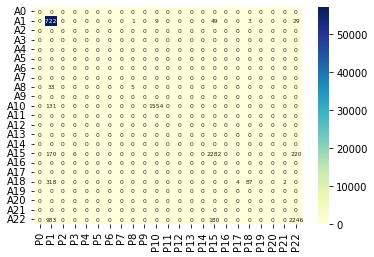

In [31]:
# Get the maximum probability for each class across the two models
minOutput = np.minimum(outputs1, outputs2)

# Display the images and masks
display([image[0], mask[0], create_mask(outputs1), create_mask(outputs2), create_mask(minOutput)])

# After max ensemble
print("Max Ensemble:\n")
evaluateMask(mask[0], create_mask(minOutput))

# Ensemble 5 - Median Ensemble

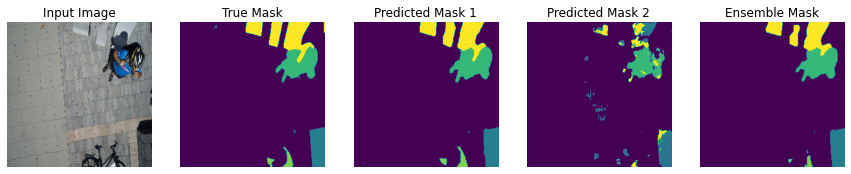

Median Ensemble:



c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           1       0.99      1.00      0.99     57315
           8       0.83      0.13      0.23        38
          10       0.99      0.97      0.98      1685
          15       0.93      0.97      0.95      2678
          17       0.00      0.00      0.00         0
          18       1.00      0.45      0.62       411
          22       0.99      0.82      0.90      3409

    accuracy                           0.98     65536
   macro avg       0.82      0.62      0.67     65536
weighted avg       0.98      0.98      0.98     65536

Mean IoU score: 0.9829619
Recall: 0.18847460057237717
Precision: 0.2488617673406772
Accuracy: 0.9834442138671875
F1 score: 0.20259088662815206
Dice coefficient: 0.20259088662815206


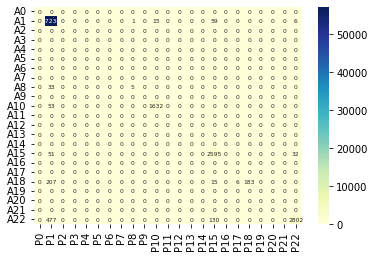

In [32]:
# Get the median probability for each class across the two models
medianOutput = np.median([outputs1, outputs2], axis=0)

# Display the images and masks
display([image[0], mask[0], create_mask(outputs1), create_mask(outputs2), create_mask(medianOutput)])

# After median ensemble
print("Median Ensemble:\n")
evaluateMask(mask[0], create_mask(medianOutput))

# Ensemble 6 - Majority Voting Ensemble

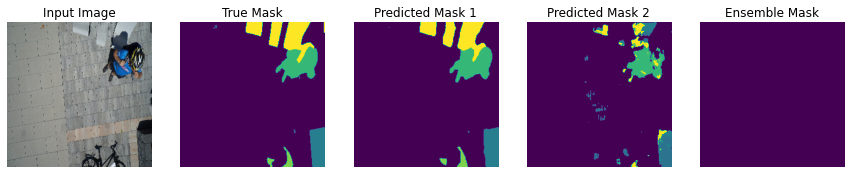

Majority Voting Ensemble:



c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3\envs\open-cv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leekh\anaconda3

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00   57315.0
           8       0.00      0.00      0.00      38.0
          10       0.00      0.00      0.00    1685.0
          15       0.00      0.00      0.00    2678.0
          18       0.00      0.00      0.00     411.0
          22       0.00      0.00      0.00    3409.0

    accuracy                           0.00   65536.0
   macro avg       0.00      0.00      0.00   65536.0
weighted avg       0.00      0.00      0.00   65536.0

Mean IoU score: 0.45652175
Recall: 0.0
Precision: 0.0
Accuracy: 0.0
F1 score: 0.0
Dice coefficient: 0.0


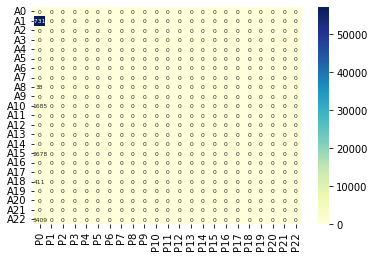

In [33]:
# Get the predicted class indices for each model's output
class_indices1 = tf.argmax(outputs1, axis=-1)
class_indices2 = tf.argmax(outputs2, axis=-1)

# Get the total number of pixels
num_pixels = class_indices1.shape[1] * class_indices1.shape[2]

# Create an empty array to store the final class indices
final_class_indices = np.zeros((num_pixels,), dtype=np.int32)

# Loop over each pixel and get the majority vote
for i in range(num_pixels):
    # Get the class indices for each model's output at this pixel
    class_index1 = class_indices1[0, i // class_indices1.shape[2], i % class_indices1.shape[2]]
    class_index2 = class_indices2[0, i // class_indices2.shape[2], i % class_indices2.shape[2]]
    
    # Get the majority vote for the two models
    if class_index1 == class_index2:
        final_class_index = class_index1
    else:
        final_class_index = np.argmax(np.bincount([class_index1, class_index2]))
    
    # Store the final class index
    final_class_indices[i] = final_class_index

# Reshape the final class indices to the shape of the original mask
final_class_indices = final_class_indices.reshape((1, class_indices1.shape[1], class_indices1.shape[2], 1))

# Display the images and masks
display([image[0], mask[0], create_mask(outputs1), create_mask(outputs2), create_mask(final_class_indices)])

# After Majority Voting Ensemble
print("Majority Voting Ensemble:\n")
evaluateMask(mask[0], create_mask(final_class_indices))

### Best Ensemble Model - Model Averaging (Weighted)

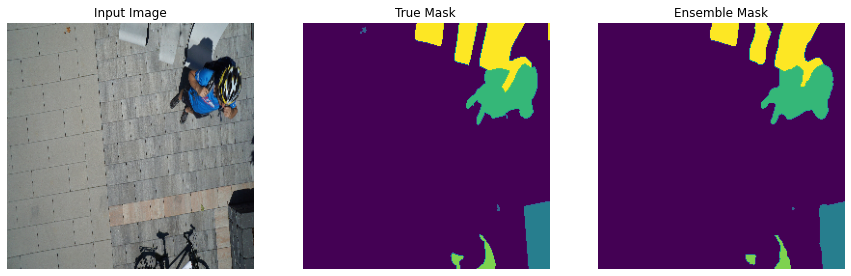

Model Averaging (Weighted):

Classification Report:
               precision    recall  f1-score   support

           1       0.99      1.00      0.99     57315
           8       0.86      0.16      0.27        38
          10       0.97      0.99      0.98      1685
          15       0.93      0.98      0.95      2678
          18       0.93      0.83      0.88       411
          22       0.98      0.91      0.95      3409

    accuracy                           0.99     65536
   macro avg       0.94      0.81      0.84     65536
weighted avg       0.99      0.99      0.99     65536

Mean IoU score: 0.9892123
Recall: 0.2117983603592957
Precision: 0.2464839653829284
Accuracy: 0.9895782470703125
F1 score: 0.2184428712303119
Dice coefficient: 0.21844287123031186


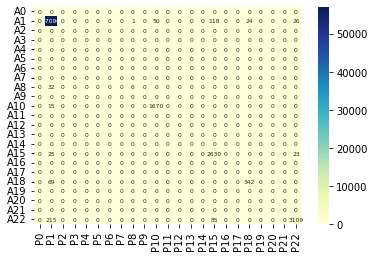

In [34]:
# Define the weights for each model's prediction
weights = [0.8, 0.2]
    
weightedOutput = np.average([outputs1, outputs2], axis=0, weights=weights)
    
display_list = [image[0], mask[0], create_mask(weightedOutput)]

plt.figure(figsize=(15, 15))

title = ['Input Image', 'True Mask', 'Ensemble Mask']

for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
plt.show()

# After model averaging (Weighted)
print("Model Averaging (Weighted):\n")
evaluateMask(mask[0], create_mask(weightedOutput))